In [1]:
# Standard library
import gzip
import json
import pickle

# Data handling & visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Imbalanced learning
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Import Data

In [4]:
def wrangle(file_path):
    with gzip.open(file_path, 'r') as f:
        data = json.load(f)

    df = pd.DataFrame().from_dict(data['data']).set_index('company_id')
    return df

In [5]:
df = wrangle('/content/drive/MyDrive/Machine Learning/Machine Learning Projects/Bankruptcy in Poland/Data/poland-bankruptcy-data-2009.json.gz')
print(df.shape)
df.head(2)

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.17419,0.41299,0.14371,1.3480,-28.9820,0.60383,0.21946,1.1225,1.1961,0.46359,...,0.163960,0.37574,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.14624,0.46038,0.28230,1.6294,2.5952,0.00000,0.17185,1.1721,1.6018,0.53962,...,0.027516,0.27100,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False


# Explore

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9977 entries, 1 to 10503
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feat_1    9977 non-null   float64
 1   feat_2    9977 non-null   float64
 2   feat_3    9977 non-null   float64
 3   feat_4    9960 non-null   float64
 4   feat_5    9952 non-null   float64
 5   feat_6    9977 non-null   float64
 6   feat_7    9977 non-null   float64
 7   feat_8    9964 non-null   float64
 8   feat_9    9974 non-null   float64
 9   feat_10   9977 non-null   float64
 10  feat_11   9977 non-null   float64
 11  feat_12   9960 non-null   float64
 12  feat_13   9935 non-null   float64
 13  feat_14   9977 non-null   float64
 14  feat_15   9970 non-null   float64
 15  feat_16   9964 non-null   float64
 16  feat_17   9964 non-null   float64
 17  feat_18   9977 non-null   float64
 18  feat_19   9935 non-null   float64
 19  feat_20   9935 non-null   float64
 20  feat_21   9205 non-null   float64


In [7]:
df.isnull().sum()

# there are small number of missing values, in future we can impute them

,0
feat_1,0
feat_2,0
feat_3,0
feat_4,17
feat_5,25
...,...
feat_61,16
feat_62,42
feat_63,17
feat_64,212


In [8]:
df["bankrupt"].value_counts(normalize=True)

,proportion
bankrupt,
False,0.953192
True,0.046808


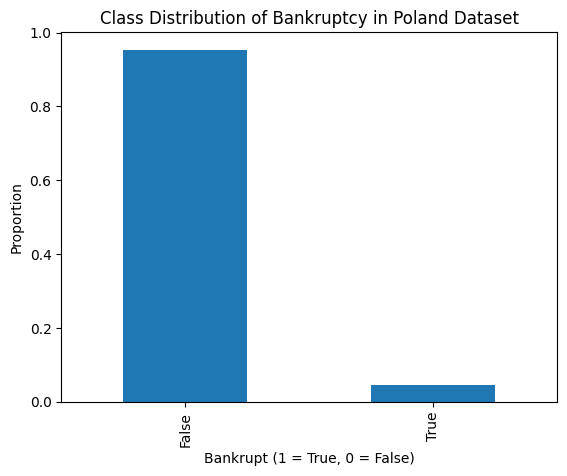

In [9]:
df["bankrupt"].value_counts(normalize=True).plot(
    kind='bar',
    title='Class Distribution of Bankruptcy in Poland Dataset',
    ylabel='Proportion',
    xlabel='Bankrupt (1 = True, 0 = False)',
);

# The dataset is highly imbalanced so we wll need to use resampling techniques in future modeling steps.

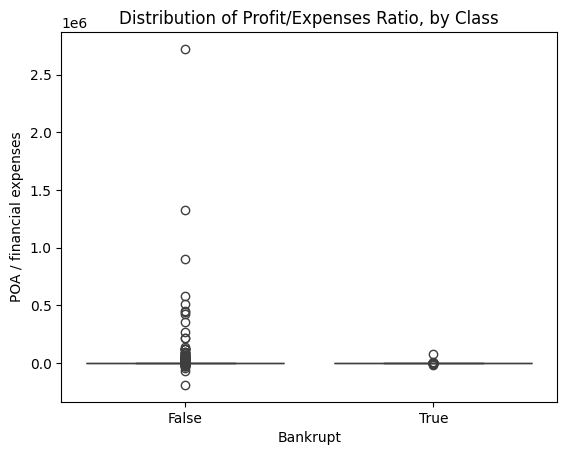

In [10]:
sns.boxplot(x="bankrupt", y="feat_27", data=df)
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Class");

# let's look why this looks like this

In [11]:
# Summary statistics for 'feat_27'
df["feat_27"].describe().apply("{0:,.0f}".format)

# we ne to use quantile limits to better visualize the data

,feat_27
count,"9,312"
mean,"1,206"
std,"35,477"
min,"-190,130"
25%,0
50%,1
75%,5
max,"2,723,000"


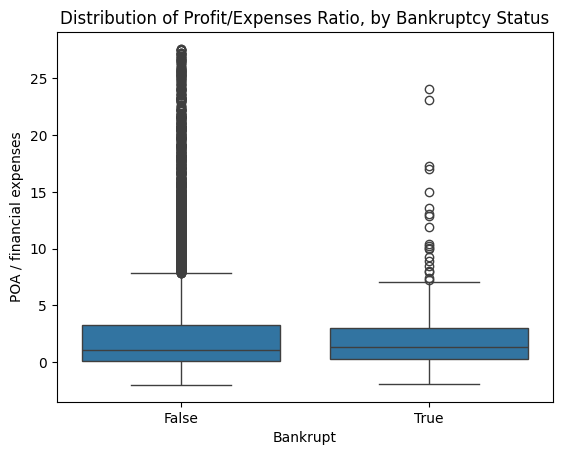

In [12]:
# Create clipped boxplot
q1, q9 = df["feat_27"].quantile([0.1, 0.9])
mask = df["feat_27"].between(q1, q9)
sns.boxplot(x="bankrupt", y="feat_27", data=df[mask])
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Bankruptcy Status");

# this looks better

# Split

In [13]:
target = "bankrupt"
X = df.drop(columns=[target])
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.2), random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


# Build Model

## Baseline

In [15]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9531


## Decision Tree Classifier

In [16]:
clf = Pipeline(
    steps=[
        ("simpleimputer", SimpleImputer()),
        ("sampler", RandomOverSampler(random_state=42)),
        ("decisiontreeclassifier", DecisionTreeClassifier(random_state=42))
    ]
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('sampler', RandomOverSampler(random_state=42)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])


In [17]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "decisiontreeclassifier__max_depth": [3, 5, 7, 10, 15, 20, 30]
}

model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('sampler',
                                        RandomOverSampler(random_state=42)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [3, 5, 7, 10, 15,
                                                               20, 30],
                         'simpleimputer__strategy': ['mean', 'median']},
             scoring='roc_auc', verbose=1)

In [18]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__max_depth,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.797583,0.107903,0.00949,0.000493,5,median,"{'decisiontreeclassifier__max_depth': 5, 'simp...",0.796798,0.801666,0.838383,0.817607,0.734666,0.797824,0.034759,1


In [19]:
model.best_params_

{'decisiontreeclassifier__max_depth': 5, 'simpleimputer__strategy': 'median'}

## Evaluate DT Model

In [20]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.8854
Validation Accuracy: 0.746


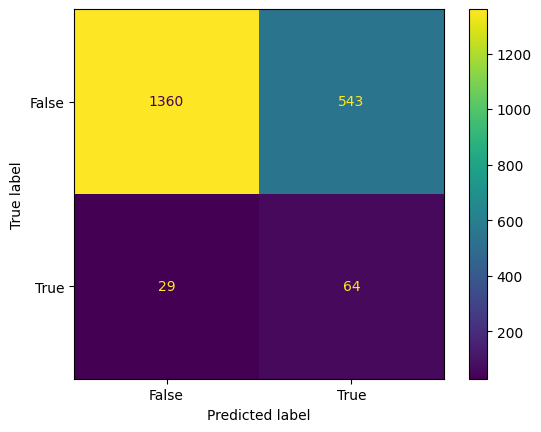

In [21]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [22]:
# Print classification report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.98      0.71      0.83      1903
        True       0.11      0.69      0.18        93

    accuracy                           0.71      1996
   macro avg       0.54      0.70      0.50      1996
weighted avg       0.94      0.71      0.80      1996



The Decision Tree model prioritizes recall for the minority (bankrupt) class, successfully identifying approximately 69% of bankrupt firms, but at the cost of a high false positive rate. This trade-off is expected given the class imbalance and oversampling strategy.

## Random Forest Model

In [23]:
clf = Pipeline(
    steps=[
        ("simpleimputer", SimpleImputer(strategy="median")),
        ("sampler", RandomOverSampler(random_state=42)),
        ("randomforestclassifier", RandomForestClassifier(
            random_state=42,
            n_jobs=-1
        ))
    ]
)

In [24]:
params = {
    "randomforestclassifier__n_estimators": [100, 200, 300, 400],
    "randomforestclassifier__max_depth": [None, 5, 10, 20],
    "randomforestclassifier__min_samples_leaf": [1, 5, 10, 15],
    "randomforestclassifier__max_features": ["sqrt", "log2"]
}


model_RF = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

model_RF.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('sampler',
                                        RandomOverSampler(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [None, 5, 10, 20],
                         'randomforestclassifier__max_features': ['sqrt',
                                                                  'log2'],
                         'randomforestclassifier__min_samples_leaf': [1, 5, 10,
                                                                      15],
                         'randomforestclassifier__n_estimators': [100, 200, 300,
                                                                  400]},
             scoring='roc_auc', verbose=1)

In [25]:
model_RF.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_samples_leaf': 10,
 'randomforestclassifier__n_estimators': 300}

In [26]:
acc_train = model_RF.score(X_train, y_train)
acc_test = model_RF.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Validation Accuracy: 0.8434


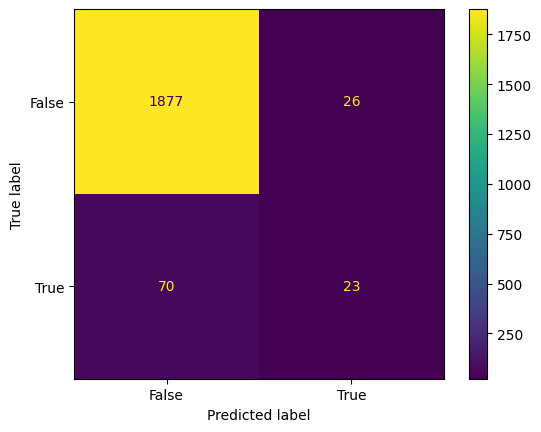

In [28]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_RF, X_test, y_test)

In [29]:
# Print classification report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.98      0.71      0.83      1903
        True       0.11      0.69      0.18        93

    accuracy                           0.71      1996
   macro avg       0.54      0.70      0.50      1996
weighted avg       0.94      0.71      0.80      1996



In [31]:
y_proba = model_RF.predict_proba(X_test)[:, 1]

for t in [0.5, 0.6, 0.7, 0.8]:
    y_pred = (y_proba >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred))



Threshold = 0.5
              precision    recall  f1-score   support

       False       0.96      0.99      0.98      1903
        True       0.47      0.25      0.32        93

    accuracy                           0.95      1996
   macro avg       0.72      0.62      0.65      1996
weighted avg       0.94      0.95      0.94      1996


Threshold = 0.6
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      1903
        True       0.62      0.14      0.23        93

    accuracy                           0.96      1996
   macro avg       0.79      0.57      0.60      1996
weighted avg       0.94      0.96      0.94      1996


Threshold = 0.7
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      1903
        True       0.73      0.09      0.15        93

    accuracy                           0.96      1996
   macro avg       0.84      0.54      0.57      1996
weighted avg       0.95

In [32]:
for t in [0.3, 0.35, 0.4, 0.45, 0.5]:
    y_pred = (y_proba >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred))



Threshold = 0.3
              precision    recall  f1-score   support

       False       0.98      0.93      0.95      1903
        True       0.26      0.52      0.34        93

    accuracy                           0.91      1996
   macro avg       0.62      0.72      0.65      1996
weighted avg       0.94      0.91      0.92      1996


Threshold = 0.35
              precision    recall  f1-score   support

       False       0.97      0.95      0.96      1903
        True       0.29      0.41      0.34        93

    accuracy                           0.93      1996
   macro avg       0.63      0.68      0.65      1996
weighted avg       0.94      0.93      0.93      1996


Threshold = 0.4
              precision    recall  f1-score   support

       False       0.97      0.97      0.97      1903
        True       0.34      0.33      0.34        93

    accuracy                           0.94      1996
   macro avg       0.66      0.65      0.65      1996
weighted avg       0.9

✅ Threshold = 0.30 — Best for Bankruptcy Screening

              precision    recall  f1-score   support

       False       0.98      0.93      0.95      1903
        True       0.26      0.52      0.34        93

    accuracy                           0.91      1996
   macro avg       0.62      0.72      0.65      1996
weighted avg       0.94      0.91      0.92      1996



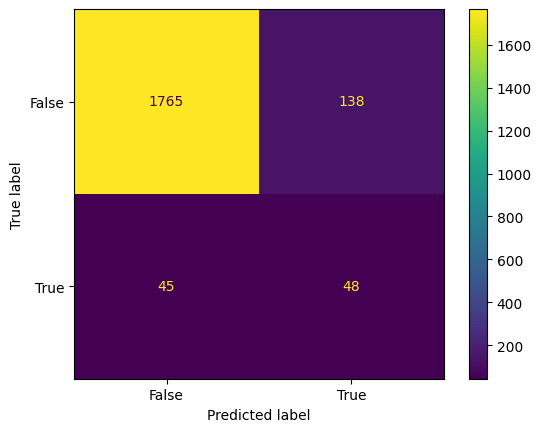

In [33]:
final_threshold = 0.30

y_final = (y_proba >= final_threshold).astype(int)

print(classification_report(y_test, y_final))
ConfusionMatrixDisplay.from_predictions(y_test, y_final)


The final Random Forest model, evaluated with a tuned classification threshold of 0.30, correctly identified 52% of bankrupt firms while maintaining a low false positive rate of approximately 7%. This configuration balances early detection of financial distress with operational feasibility, making it suitable for bankruptcy risk screening.

In [34]:
# Save model
with open("/content/drive/MyDrive/Machine Learning/Machine Learning Projects/Bankruptcy in Poland/Random-Forest-model.pkl", "wb") as file:
    pickle.dump(model, file)